<a href="https://colab.research.google.com/github/rakesh4real/one-or-few-shot-learning/blob/main/siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random, time, pickle, os
import numpy as np
import matplotlib.pyplot as plt   

import torch
import torch.nn as nn
from torchvision import datasets
from torch.autograd import Variable
from torchvision import transforms

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print('Seed is: ', seed)
    
    
SEED = 123
seed_everything(SEED)

Seed is:  123


# 1. Prepare Dataset

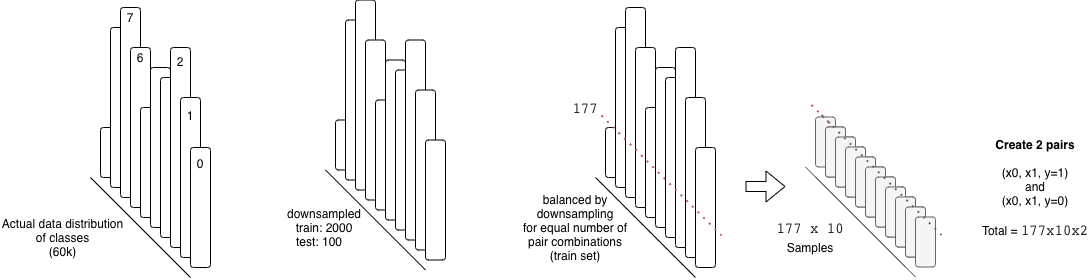

In [3]:
class DatasetIterator:
    '''
    Input: numpy values
    Output: torch variables.
    '''
    def __init__(self, x0, x1, label):
        self.size = label.shape[0] 
        self.x0 = torch.from_numpy(x0)
        self.x1 = torch.from_numpy(x1)
        self.label = torch.from_numpy(label)

    def __getitem__(self, index):
        return (self.x0[index],
                self.x1[index],
                self.label[index])

    def __len__(self):
        return self.size

In [6]:
def create_pairs(data, digit_indices):
    '''
    input
    -----
      data: 
        xs (downsampled data)
      digit_indices: 
        `n_classes` sized list. 
        Each idx corresponding to the actual class 
        label and the location of all those class 
        samples in whole dataset
    '''
    
    x0_data = []
    x1_data = []
    label = []
    
    # downsample dataset to the size of class with least
    # sample points. Cz, equal number of pairs must be formed.
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    print('Downsample each class to: ', n, ' sample points')
    print(f'Total pairs per label = {n}*10 = {n*10}')
    print(f'Total similar and dissimilar combinations = 2*{n*10} = {2*n*10}')
    print("\n\n")

    for d in range(10): # for all 10 classes
        for i in range(n): 
            # 10*177

            # similar pairs (y=1)
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            x0_data.append(data[z1] / 255.) 
            x1_data.append(data[z2] / 255.) 
            label.append(1)
            
            # dissimilar pairs (y=2) [randomly]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            x0_data.append(data[z1] / 255.) 
            x1_data.append(data[z2] / 255.)
            label.append(0)

    x0_data = np.array(x0_data, dtype=np.float32)
    x0_data = x0_data.reshape([-1, 1, 28, 28])
    x1_data = np.array(x1_data, dtype=np.float32)
    x1_data = x1_data.reshape([-1, 1, 28, 28])
    label = np.array(label, dtype=np.int32)
    return x0_data, x1_data, label

In [21]:
def create_iterator(data, label): 
    '''
    input   : xs, label (i.e data, actual_labels)
    output  : x0, x1, similar_or_not (iterator)
    '''

    digit_indices = [np.where(label == i)[0] for i in range(10)]
    x0, x1, label = create_pairs(data, digit_indices)
    return DatasetIterator(x0, x1, label)

In [22]:
train_sample_size = 2000
test_sample_size = 100

train = datasets.MNIST(root='../data/',train=True,download=True)
test = datasets.MNIST(root='../data/',train=False,transform=transforms.Compose([transforms.ToTensor(),]))

indices_train= np.random.choice(len(train.targets.numpy()), train_sample_size, replace=False)
indices_test= np.random.choice(len(test.targets.numpy()), test_sample_size, replace=False)

In [23]:
print('sampled train size: ', len(indices_train))
print('sampled test size: ', len(indices_test))

sampled train size:  2000
sampled test size:  100


In [24]:
train_iter = create_iterator(
    train.data.numpy()[indices_train],
    train.targets.numpy()[indices_train])

test_iter = create_iterator(
    test.data.numpy()[indices_test],
    test.targets.numpy()[indices_test])

Downsample each class to:  169  sample points
Total pairs per label = 169*10 = 1690
Total similar and dissimilar combinations = 2*1690 = 3380



Downsample each class to:  5  sample points
Total pairs per label = 5*10 = 50
Total similar and dissimilar combinations = 2*50 = 100





In [25]:
_x0, _x1, _y = next(iter(train_iter))

print("pairs' shape: ", _x0.shape, _x1.shape)
print('numeric label: ', _y)

print("\n")
print('size of train iter: ', len(train_iter))
print('size of test iter: ', len(test_iter))

pairs' shape:  torch.Size([1, 28, 28]) torch.Size([1, 28, 28])
numeric label:  tensor(1, dtype=torch.int32)


size of train iter:  3380
size of test iter:  100


## 2. Loss Function

In [26]:
def contrastive_loss_function(x0, x1, y, margin=1.0):
    # euclidean distance
    diff = x0 - x1
    dist_sq = torch.sum(torch.pow(diff, 2), 1)
    dist = torch.sqrt(dist_sq)
    mdist = margin - dist
    dist = torch.clamp(mdist, min=0.0)
    loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
    loss = torch.sum(loss) / 2.0 / x0.size()[0]
    return loss

## 3. Siamese Network

In [27]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.MaxPool2d(2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(50 * 4 * 4, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500,10),
            nn.Linear(10, 2))
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## 4. Hyperparameters and training configuration

In [32]:
# call model
model = SiameseNetwork()
lr = 0.01
momentum = 0.9

# Loss and Optimizer
criterion = contrastive_loss_function # we will use contrastive loss function as defined above
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# creating a train loader, and a test loader.
# batchsize will reflect here
train_loader = torch.utils.data.DataLoader(train_iter,batch_size=batchsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=batchsize, shuffle=True)

In [33]:
_x0, _x1, _y = next(iter(train_loader))

print("pairs' shape: ", _x0.shape, _x1.shape)
print('labels of batch: ', _y)

print("\n")
print('size of train iter: ', len(train_iter))
print('size of test iter: ', len(test_iter))

# with batchsize

pairs' shape:  torch.Size([128, 1, 28, 28]) torch.Size([128, 1, 28, 28])
labels of batch:  tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 1, 1, 1, 1, 0], dtype=torch.int32)


size of train iter:  3380
size of test iter:  100


## 5. Train

In [34]:
train_loss = []
epochs =100
for epoch in range(epochs):
    for batch_idx, (x0, x1, labels) in enumerate(train_loader):
        labels = labels.float()
        x0, x1, labels = Variable(x0), Variable(x1), Variable(labels)
        output1, output2 = model(x0, x1)
        loss = criterion(output1, output2, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if batch_idx % batchsize == 0:
            print('Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

Epoch: 0 	Loss: 0.211368
Epoch: 1 	Loss: 0.171767
Epoch: 2 	Loss: 0.108813
Epoch: 3 	Loss: 0.111423
Epoch: 4 	Loss: 0.085459
Epoch: 5 	Loss: 0.077873


KeyboardInterrupt: ignored

In [35]:
def plot_loss(train_loss,name="train_loss.png"):
    plt.plot(train_loss, label="train loss")
    plt.legend()

def plot_mnist(numpy_all, numpy_labels,name="./embeddings_plot.png"):
        c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
             '#ff00ff', '#990000', '#999900', '#009900', '#009999']

        for i in range(10):
            f = numpy_all[np.where(numpy_labels == i)]
            plt.plot(f[:, 0], f[:, 1], '.', c=c[i])
        plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
        plt.savefig(name)

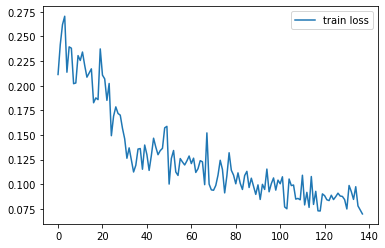

In [36]:
plot_loss(train_loss)

In [37]:
def test_model(model):
        model.eval()
        all_ = []
        all_labels = []
        with torch.no_grad():
            for batch_idx, (x, labels) in enumerate(test_loader):
                x, labels = Variable(x), Variable(labels)
                output = model.forward_once(x)
                all_.extend(output.data.cpu().numpy().tolist())
                all_labels.extend(labels.data.cpu().numpy().tolist())

        numpy_all = np.array(all_)
        numpy_labels = np.array(all_labels)
        return numpy_all, numpy_labels

def testing_plots(model):
        dict_pickle={}
        numpy_all, numpy_labels = test_model(model)
        dict_pickle["numpy_all"]=numpy_all
        dict_pickle["numpy_labels"]=numpy_labels
        plot_mnist(numpy_all, numpy_labels)

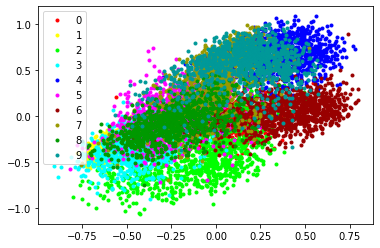

In [38]:
testing_plots(model)